In [1]:
# Load the required packages 
import pandas as pd
import numpy as np
import seaborn as sns
import time
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import GridSearchCV
from umap import UMAP
from sklearn.cluster import DBSCAN
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler
from scipy.stats import entropy
from matplotlib import pyplot as plt
from sklearn.metrics import silhouette_score

In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "3"
os.environ["MKL_NUM_THREADS"] = "3"
print(os.getcwd())

C:\Users\BRYEMM004\Desktop\MSc\MSc_Data_sets


In [3]:
# Load the gene level expression matrix eset_HTA20. 
hta_df = pd.read_csv("HTA20_RMA.xlsx", sep = " ")

In [4]:
hta_df.head()

,Tarca_001_P1A01,Tarca_003_P1A03,Tarca_004_P1A04,Tarca_005_P1A05,Tarca_006_P1A06,Tarca_007_P1A07,Tarca_008_P1A08,Tarca_011_P1A11,Tarca_012_P1A12,Tarca_013_P1B01,...,Tarca_911_P10G06,Tarca_912_P10H06,Tarca_913_P10A07,Tarca_914_P10B07,Tarca_915_P10C07,Tarca_916_P10D07,Tarca_917_P10E07,Tarca_918_P10F07,Tarca_919_P10G07,Tarca_920_P10H07
1_at,6.062215,6.125023,5.875502,6.126131,6.146466,6.134555,6.289534,6.320997,6.185504,6.085618,...,6.123887,6.092937,6.374775,6.199526,6.244360,6.277895,6.365038,6.341189,6.433980,6.254807
10_at,3.796484,3.805305,3.450245,3.628411,3.446812,3.512325,3.568193,3.584622,3.696258,3.549118,...,3.642128,3.543872,4.165844,3.725332,3.536598,3.708818,3.773754,3.970478,3.749549,3.599263
100_at,5.849338,6.191562,6.550525,6.421877,6.260962,6.154893,6.348074,6.175742,6.179713,6.117801,...,6.216938,6.161236,6.371440,6.181719,6.195250,6.276257,6.221597,6.186570,6.213764,6.329449
1000_at,3.567779,3.452524,3.316134,3.432451,3.477162,3.638140,3.399044,3.787394,3.452014,3.542147,...,3.579528,3.509152,3.654649,3.760908,3.601202,3.763030,3.775920,3.712024,3.769967,3.718142
10000_at,6.166815,5.678373,6.185059,5.633757,5.313198,5.148149,5.640643,5.270906,5.694625,6.257552,...,5.733829,5.913966,5.650307,5.630868,5.488366,5.424940,5.350965,5.605535,5.379500,5.513927


In [5]:
# Check the size of the data(32,830 rows x 735 columns)
hta_df.shape

(32830, 735)

In [6]:
# Check for missing values
hta_df.isnull().sum()

Tarca_001_P1A01     0
Tarca_003_P1A03     0
Tarca_004_P1A04     0
Tarca_005_P1A05     0
Tarca_006_P1A06     0
                   ..
Tarca_916_P10D07    0
Tarca_917_P10E07    0
Tarca_918_P10F07    0
Tarca_919_P10G07    0
Tarca_920_P10H07    0
Length: 735, dtype: int64

# Data Filtering and Reduction
In this section the code will carry out a multi-step filtering process to reduce 
the number of genes based on variance, fold change, and entropy criteria. 
It iteratively applies these filters until the number of genes is reduced to or below a specified limit (filterLimit). 

In [7]:
# Set the maximum number of genes to keep after filtering
filterLimit = 2000 
##This is data preparation 
# Get expression values, gene names, and samples . Here we are Extracting expression data(rows represent genes and columns represent samples, and the first column is gene names).
expression = hta_df.iloc[:, 1:].values
samples = hta_df.columns[1:]
genes = hta_df.iloc[:, 0].values

# Remove rows with NaN values
nanIndices = np.any(np.isnan(expression), axis=1) #Finding rows (genes) with NaN values and creating a boolean array of indices (nanIndices).
expression = expression[~nanIndices] #Removing genes with NaN values from the expression data.
genes = genes[~nanIndices] #Updating the list of gene names accordingly.

##Filtering Loop (while loop): This loop iterates until the number of genes (len(genes)) is reduced to or below filterLimit (300 in this case).
#Filtering Steps: include Variance Filtering, Fold Change Threshold, and Entropy Filtering.

while len(genes) > filterLimit:
    # Filter based on variance
    variance = np.var(expression, axis=1) #Calculating variance across samples for each gene.
    high_variance_indices = variance > np.percentile(variance, 100 - (filterLimit/len(genes) * 100)) # Selecting genes with high variance above a certain percentile threshold.
    expression = expression[high_variance_indices, :] #Updating expression and genes based on high_variance_indices.
    genes = genes[high_variance_indices] #Updating expression and genes based on high_variance_indices.
    
    if len(genes) <= filterLimit:
        break  # Stop if we've reduced to or below the target number of genes
    
    # Apply fold change threshold
    fold_change_threshold = np.log2(2) #Setting a threshold for fold change (log2 scale).
    fold_changes = np.var(expression, axis=1) #Calculating variance again (potentially redundant, but may represent a simplification for the example).
    high_fold_change_indices = fold_changes > fold_change_threshold #Selecting genes with variance (interpreted as fold change here) above the threshold.
    expression = expression[high_fold_change_indices, :] #Updating expression and genes based on high_fold_change_indices.
    genes = genes[high_fold_change_indices] #Updating expression and genes based on high_fold_change_indices.
    
    if len(genes) <= filterLimit:
        break  # Stop if we've reduced to or below the target number of genes
    
    # Filter based on entropy
    entropies = entropy(expression, axis=1) #Calculating entropy for each gene.
    high_entropy_indices = entropies > np.percentile(entropies, 80) #Selecting genes with high entropy above a certain percentile threshold.
    expression = expression[high_entropy_indices, :] #Updating expression and genes based on high_entropy_indices.
    genes = genes[high_entropy_indices] #Updating expression and genes based on high_entropy_indices.

# Check final sizes # After the loop finishes, the code prints: Final number of genes (Number of genes remaining after filtering.) and Shape of expression data (Shape of the final expression data array).
print(f"Final number of genes: {len(genes)}")
print(f"Shape of expression data: {expression.shape}")

Final number of genes: 2000
Shape of expression data: (2000, 734)


In [8]:
#Normalization of Expression Data
scaler = StandardScaler() #standardize (mean=0, variance=1) each feature (gene expression in this case) across samples.
expression_scaled = scaler.fit_transform(expression.T).T #fit_transform() computes the mean and standard deviation from the data and then applies transformation (expression.T)

In [9]:
#Finding Optimal Number of Clusters using Silhouette Score
range_n_clusters = [2, 3, 4, 5] #specifies the range of cluster numbers (2 to 5 clusters).
silhouette_avg = [] #store the silhouette scores for each number of clusters
for n_clusters in range_n_clusters:  #A loop iterates over each n_clusters value
    clusterer = kmeans = KMeans(n_clusters=4, n_init=10, random_state=10) #initializes the KMeans clustering model with n_clusters.
    cluster_labels = clusterer.fit_predict(expression_scaled.T) #fits the model to the transposed scaled data and predicts cluster labels.
    silhouette_avg.append(silhouette_score(expression_scaled.T, cluster_labels)) #computes the silhouette score for the clustering result.

C:\Users\BRYEMM004\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\BRYEMM004\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\BRYEMM004\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\BRYEMM004\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmea

In [10]:
#Identifying the Optimal Number of Clusters
optimal_n_clusters = range_n_clusters[np.argmax(silhouette_avg)]

## K-means Clustering and Parameter Selection

In [11]:
#Print the Optimal Number of Clusters
print(f"Optimal number of clusters: {optimal_n_clusters}")

Optimal number of clusters: 2


In [12]:
# K-means clustering
kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=10)
idx = kmeans.fit_predict(expression_scaled.T)

C:\Users\BRYEMM004\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


## Data Visualization with PCA

In [93]:
# PCA for visualization
pca = PCA(n_components=2) #Initializes a PCA object with n_components=2, -To reduce the dimensionality of the data to two principal components.
principal_components = pca.fit_transform(expression_scaled.T) #Performs PCA on the transposed scaled data (expression_scaled.T) and transforms it into a 2-dimensional space (principal_components).

# Specify the legend names
unique_labels = np.unique(idx) # This returns the unique elements of the array "idx". idx likely represents the labels for different subtypes or classes in your data.
lgNames = [f"Subtype-{label}" for label in unique_labels] #Creates a list "lgNames" where each element is formatted as a string "Subtype-X", where X is a unique label from "unique_labels"

# Define colors for each label
colors = {0: 'r', 1: 'b'}
c = [colors[label] for label in idx]

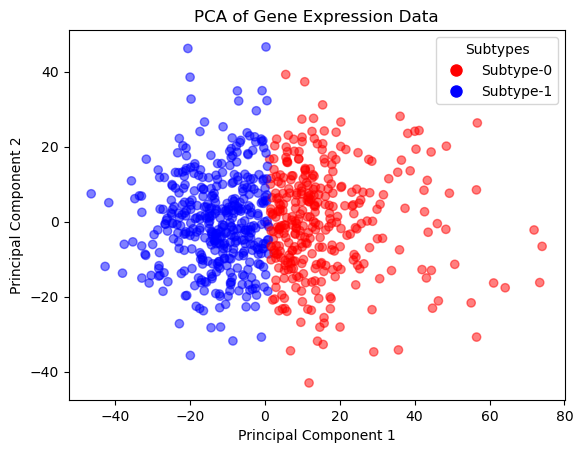

In [94]:
# Plot PCA results
plt.figure()
scatter = plt.scatter(principal_components[:, 0], principal_components[:, 1], c=c, alpha=0.5)
plt.title('PCA of Gene Expression Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Create a legend with custom handles
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[label], markersize=10, label=lgNames[i])
           for i, label in enumerate(unique_labels)]
plt.legend(handles=handles, title="Subtypes")

plt.show()

## Data Visualization with t-SNE

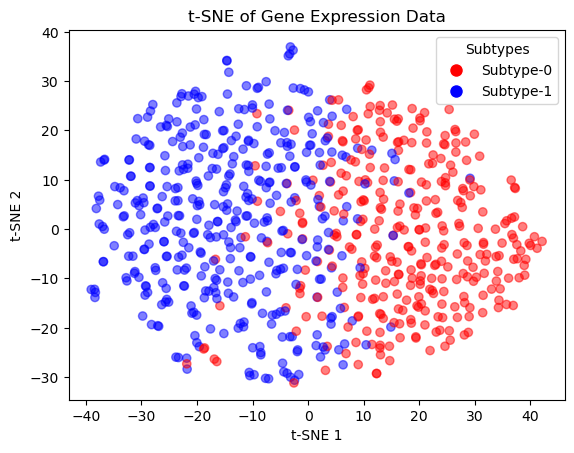

In [95]:
# t-SNE for visualization
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(expression_scaled.T)

# Specify the legend names
unique_labels = np.unique(idx)
lgNames = [f"Subtype-{label}" for label in unique_labels]

# Define colors for each label
colors = {0: 'r', 1: 'b'}
c = [colors[label] for label in idx]

# Specify the legend names
unique_labels = np.unique(idx)
lgNames = [f"Subtype-{label}" for label in unique_labels]

# Plot t-SNE results
plt.figure()
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=c, alpha=0.5)
plt.title('t-SNE of Gene Expression Data')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

# Create a legend with custom handles
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[label], markersize=10, label=lgNames[i])
           for i, label in enumerate(unique_labels)]
plt.legend(handles=handles, title="Subtypes")

plt.show()

### Data Visualization with t-SNE after Hyperparameter Optimising

In [97]:
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'perplexity': [5, 10, 20, 30, 40, 50],
    'learning_rate': [10, 50, 100, 200, 500, 1000],
    'max_iter': [250, 500, 1000, 2000],
    'early_exaggeration': [8, 12, 16, 24],
    'metric': ['euclidean', 'manhattan', 'cosine'],
    'random_state' : [0],
    'angle': [0,0.25,0.5,0.75,1]
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=tsne,
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter settings to try
    scoring='neg_mean_squared_error',  # Placeholder scoring; will use silhouette_scorer
    cv=3,  # Number of cross-validation folds
    verbose=1,
    n_jobs=-1,
    random_state=0
)

# Fit RandomizedSearchCV
random_search.fit(expression_scaled.T)  # Replace 'data' with your dataset

# Evaluate best parameters and score
best_params = random_search.best_params_
best_score = -random_search.best_score_  # Negate because we used negative mean squared error as placeholder

print(f"Best parameters: {best_params}")
print(f"Best silhouette score: {best_score}")
# Use GridSearchCV or a similar approach to find best parameters
# Note: GridSearchCV requires a scoring function, which is not straightforward for t-SNE



Fitting 3 folds for each of 50 candidates, totalling 150 fits


C:\Users\BRYEMM004\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best parameters: {'random_state': 0, 'perplexity': 20, 'metric': 'cosine', 'max_iter': 2000, 'learning_rate': 50, 'early_exaggeration': 16, 'angle': 0.25}
Best silhouette score: nan


### Visualisation with t-SNE using the dtermined Hyperparameters 

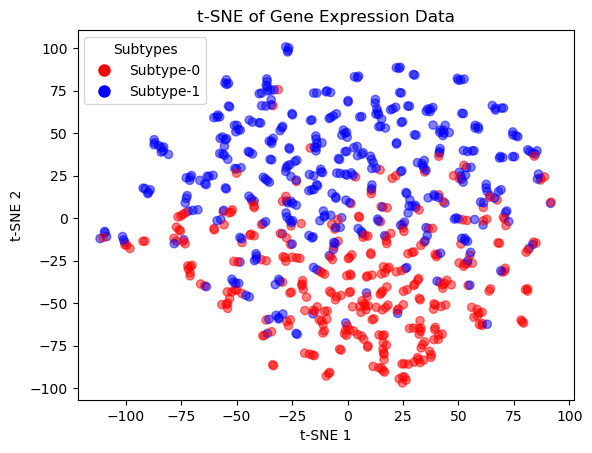

In [101]:
# t-SNE for visualization
tsne = TSNE(n_components=2, perplexity=5, max_iter=2000, learning_rate=50,early_exaggeration=16, metric='euclidean', angle=0.25, random_state=0)
tsne_results = tsne.fit_transform(expression_scaled.T)

# Specify the legend names
unique_labels = np.unique(idx)
lgNames = [f"Subtype-{label}" for label in unique_labels]

# Define colors for each label
colors = {0: 'r', 1: 'b'}
c = [colors[label] for label in idx]

# Specify the legend names
unique_labels = np.unique(idx)
lgNames = [f"Subtype-{label}" for label in unique_labels]

# Plot t-SNE results
plt.figure()
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=c, alpha=0.5)
plt.title('t-SNE of Gene Expression Data')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

# Create a legend with custom handles
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[label], markersize=10, label=lgNames[i])
           for i, label in enumerate(unique_labels)]
plt.legend(handles=handles, title="Subtypes")

plt.show()

### Hyperparameter tuning using manual or heuristic tuning approach.

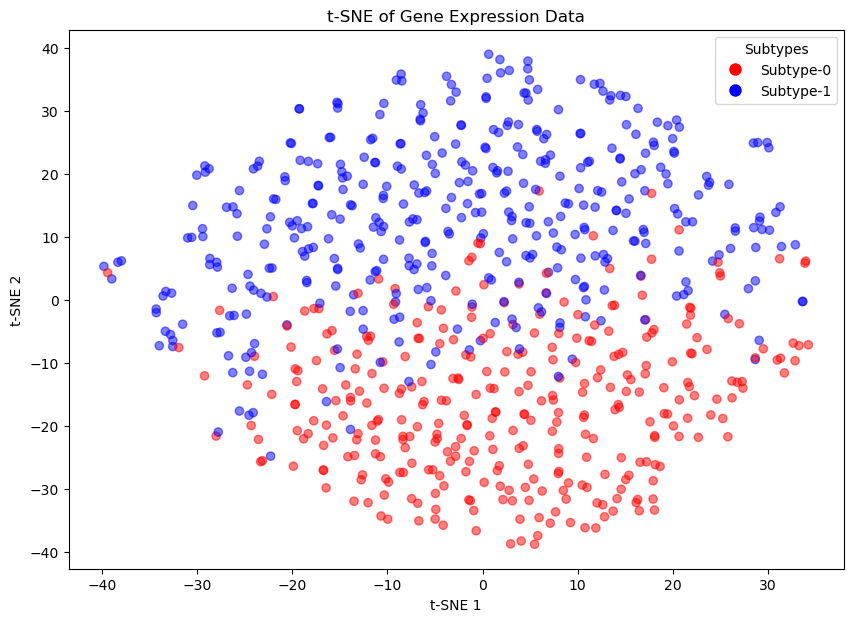

In [114]:
# Setting the random seed for reproducibility
np.random.seed(1)

# Algorithm control and hyperparameters
the_algorithm = 'barnes_hut'  # Note: In sklearn, the algorithm is called 'barnes_hut'
tnse_distance_metric = 'euclidean'  # Sklearn does not directly support 'spearman', precomputing is required
exaggeration_num = 4  # Try different values
PCAComps = 0
pca_comps = None if PCAComps == 0 else PCAComps  # sklearn uses None to signify no PCA dimensionality reduction
perp_num = 30

# Assuming expression_standardized and idx are already defined
# expression_standardized: The standardized feature matrix
# idx: The labels for different classes

# Preprocess the expression data for t-SNE
#expression_standardized = StandardScaler().fit_transform(expression.T)  # Standardizing before t-SNE

# If using 'spearman' or other non-standard metrics, precompute the distance matrix
if tnse_distance_metric == 'precomputed':
    # Compute Spearman correlation and convert to a distance matrix
    corr_matrix, _ = spearmanr(expression_standardized)
    distances = 1 - np.abs(corr_matrix)  # Convert correlation to distance

    # Running t-SNE with precomputed distances
    tsne_results = TSNE(n_components=2, metric='precomputed', perplexity=perp_num,
                        early_exaggeration=exaggeration_num, learning_rate='auto',
                        max_iter=1000, n_iter_without_progress=300, init='random',
                        random_state=1).fit_transform(distances)
else:
    # Running t-SNE with specified metric (other than 'spearman')
    tsne_results = TSNE(n_components=2, metric=tnse_distance_metric, perplexity=perp_num,
                        early_exaggeration=exaggeration_num, learning_rate='auto',
                        max_iter=1000, n_iter_without_progress=300, init='random',
                        random_state=1).fit_transform(expression_standardized)

# Specify the legend names
unique_labels = np.unique(idx)
lgNames = [f"Subtype-{label}" for label in unique_labels]

# Define colors for each label
colors = {0: 'r', 1: 'b'}
c = [colors[label] for label in idx]

# Plot t-SNE results
plt.figure(figsize=(10, 7))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=c, alpha=0.5)

# Add titles and labels
plt.title('t-SNE of Gene Expression Data')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

# Create a legend with custom handles
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[label], markersize=10, label=lgNames[i])
           for i, label in enumerate(unique_labels)]
plt.legend(handles=handles, title="Subtypes")

plt.show()

## Data Visualization with UMAP

C:\Users\BRYEMM004\AppData\Local\anaconda3\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


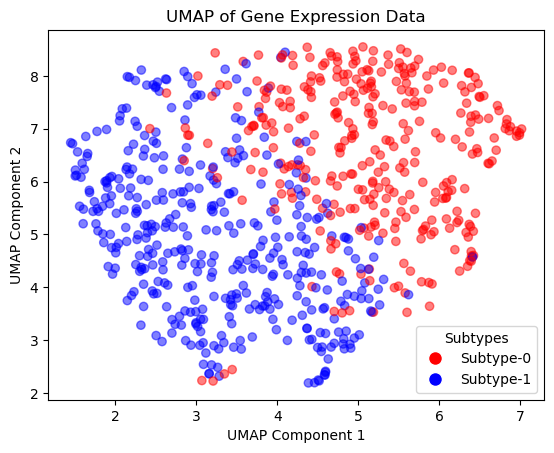

In [110]:
umap = UMAP(n_components=2, random_state=0)
embedding = umap.fit_transform(expression_scaled.T)

# Specify the legend names
unique_labels = np.unique(idx)
lgNames = [f"Subtype-{label}" for label in unique_labels]

# Define colors for each label
colors = {0: 'r', 1: 'b'}
c = [colors[label] for label in idx]

# Plot UMAP results
plt.figure()
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=c, alpha=0.5)
plt.title('UMAP of Gene Expression Data')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')

# Create a legend with custom handles
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[label], markersize=10, label=lgNames[i])
           for i, label in enumerate(unique_labels)]
plt.legend(handles=handles, title="Subtypes")
plt.show()

## Spectral Clustering

In [63]:
spectral = SpectralClustering(n_clusters=optimal_n_clusters, random_state=0, affinity='nearest_neighbors')
idx_spectral = spectral.fit_predict(expression_scaled.T)  # Use idx_spectral instead of idx

# Define colors for each label
colors = {0: 'r', 1: 'b'}
c = [colors[label] for label in idx_spectral]

C:\Users\BRYEMM004\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


## Data Visualization With PCA, UMAP and t-SNE

C:\Users\BRYEMM004\AppData\Local\anaconda3\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


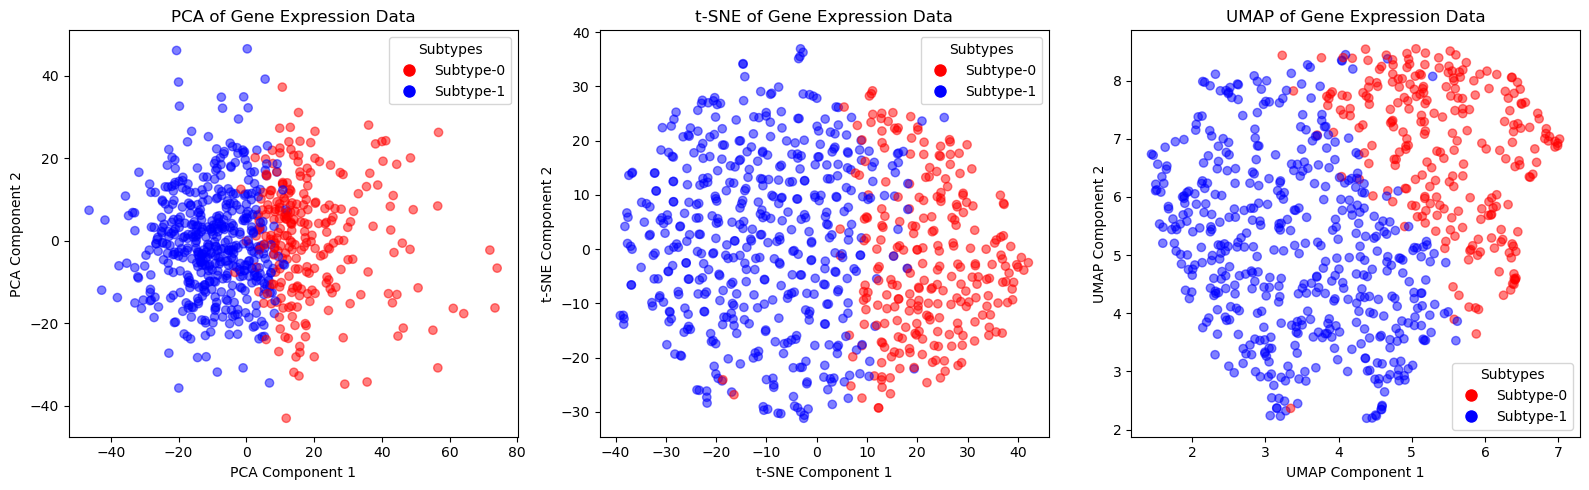

In [64]:
# Define dimensionality reduction techniques
dimensionality_reduction_methods = [
    ('PCA', PCA(n_components=2)),
    ('t-SNE', TSNE(n_components=2, random_state=0)),
    ('UMAP', UMAP(n_components=2, random_state=0))
]

# Plotting
plt.figure(figsize=(16, 5))

for i, (method_name, method) in enumerate(dimensionality_reduction_methods, start=1):
    # Fit-transform the data using the current method
    reduced_components = method.fit_transform(expression_scaled.T)
    
    # Plotting
    plt.subplot(1, 3, i)
    scatter = plt.scatter(reduced_components[:, 0], reduced_components[:, 1],c=c, alpha=0.5)
    plt.title(f'{method_name} of Gene Expression Data')
    plt.xlabel(f'{method_name} Component 1')
    plt.ylabel(f'{method_name} Component 2')
    # Create a legend with custom handles
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[label], markersize=10, label=lgNames[i])
           for i, label in enumerate(unique_labels)]
    plt.legend(handles=handles, title="Subtypes")

plt.tight_layout()
plt.show()

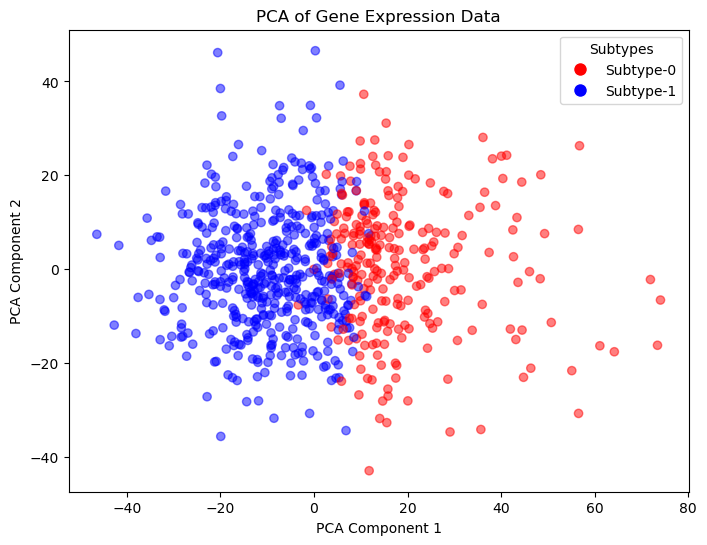

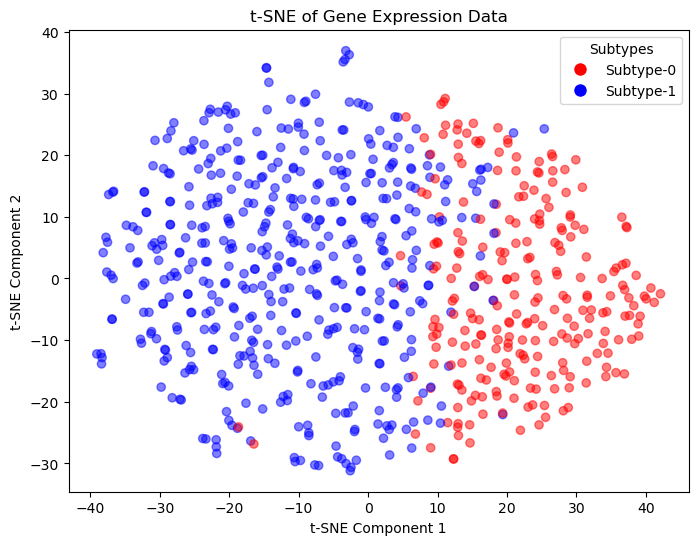

C:\Users\BRYEMM004\AppData\Local\anaconda3\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


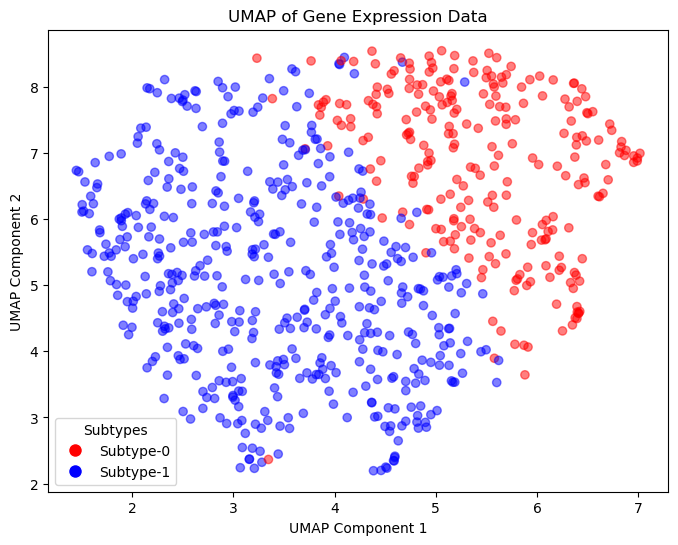

In [65]:
# Define dimensionality reduction techniques
dimensionality_reduction_methods = [
    ('PCA', PCA(n_components=2)),
    ('t-SNE', TSNE(n_components=2, random_state=0)),
    ('UMAP', UMAP(n_components=2, random_state=0))
]

# Plotting each method separately
for method_name, method in dimensionality_reduction_methods:
    # Fit-transform the data using the current method
    reduced_components = method.fit_transform(expression_scaled.T)
    
    # Specify the legend names
    unique_labels = np.unique(idx_spectral)
    lgNames = [f"Subtype-{label}" for label in unique_labels]
    
    # Plotting
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced_components[:, 0], reduced_components[:, 1], c=c, alpha=0.5)
    plt.title(f'{method_name} of Gene Expression Data')
    plt.xlabel(f'{method_name} Component 1')
    plt.ylabel(f'{method_name} Component 2')
    # Create a legend with custom handles
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[label], markersize=10, label=lgNames[i])
           for i, label in enumerate(unique_labels)]
    plt.legend(handles=handles, title="Subtypes")
    plt.show()